In [1]:
# Import libraries
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

In [2]:
# Import data
input_listings = './data/seattle/listings.csv'
input_reviews = './data/seattle/reviews.csv'
input_calendar = './data/seattle/calendar.csv'

calendar = pd.read_csv(input_calendar)
listings = pd.read_csv(input_listings)
reviews = pd.read_csv(input_reviews)

###	Q1 - What are the busiest times of the year to visit Seattle?

### Data Preparation

In [12]:
# get the year and month
calendar['year'] = pd.DatetimeIndex(calendar['date']).year
calendar['month'] = pd.DatetimeIndex(calendar['date']).month

# Since there is incomplete data in 2017, remove these rows to minimise the bias
calendar = calendar[calendar['year'] < 2017]

In [13]:
# Remove $ sign from price and convert price in str to float
calendar['price'] = calendar['price'].apply(lambda x:utils.convert2float(x))

### Availability distribution

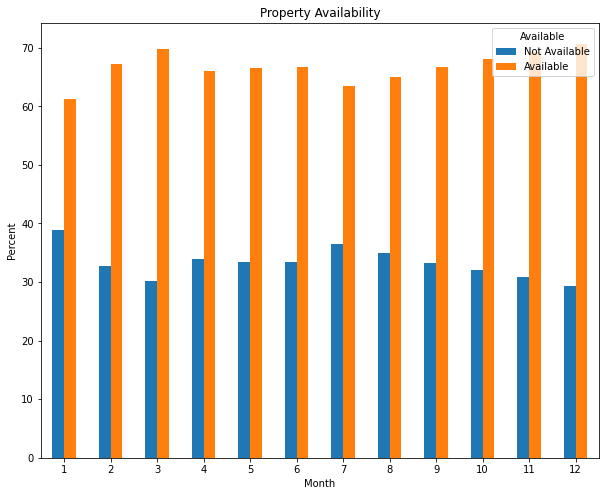

In [14]:
# plot airBnB availability
ax = pd.crosstab(calendar['month'], calendar['available']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,8), stacked=False, rot=0)
L = plt.legend(loc='upper right', title="Available")
L.get_texts()[0].set_text('Not Available')
L.get_texts()[1].set_text('Available')
plt.title("Property Availability")
plt.xlabel("Month")
plt.ylabel("Percent")
plt.show()

### Insights
The busiest time to visit Seattle is January. January has the least amount of available rental properties on AirBnB. 

### Q2. How does the price change over the year?

In [15]:
# Calculate the mean price per month
calendar_price_grouped = calendar.groupby(by=['month'])['price'].mean().reset_index()

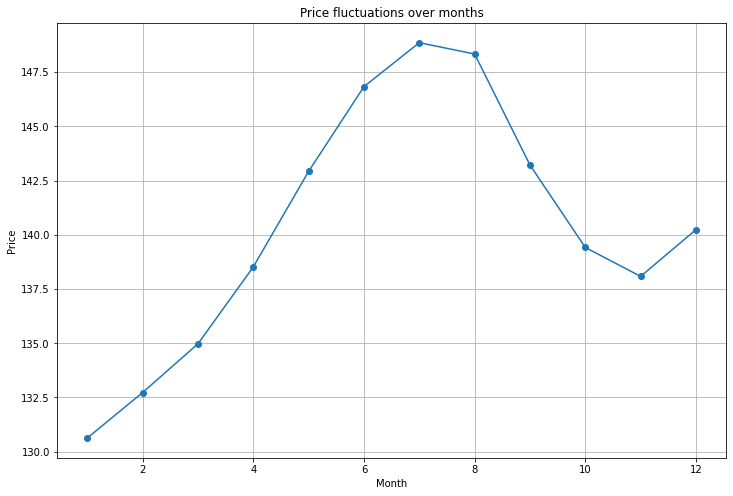

In [16]:
# plot the price line chart
plt.figure(figsize=(12,8))

plt.plot(calendar_price_grouped['month'], calendar_price_grouped['price'], marker='o')
plt.title("Price fluctuations over months")
plt.xlabel("Month")
plt.ylabel("Price")
plt.grid(True)
plt.show()

### Insights
The highest price is at July. About 60% of the properties were rented out. The lowest price was in Janaury, resulted in about 70% of properties were rented out. The price growth was pretty steady from January to the peak in July; the price then declined gradually and increased a bit again for December.

In [17]:
priceSpikePercent = round((calendar_price_grouped.iloc[6,1] - calendar_price_grouped.iloc[0,1])/calendar_price_grouped.iloc[0,1] * 100, 2)
print("The price in July was about {}% higher than the price in Jan".format(priceSpikePercent))

The price in July was about 13.96% higher than the price in Jan


### Q3 - What is the vibe of Seattle neighborhood?

In [18]:
seattleTowns = listings['neighbourhood_group_cleansed'].unique().tolist()  
seattleTowns = [town.lower().split() for town in seattleTowns]

seattleTowns_flat = [item for sublist in seattleTowns for item in sublist]

In [19]:
listings['neighborhood_overview_cleaned'] = listings['neighborhood_overview'].apply(lambda x: utils.clean_text(x, seattleTowns_flat))

In [20]:
downtown = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Downtown')
capitolHill = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Capitol Hill')
queenAnne = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Queen Anne')
ballard = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Ballard')
weatSeattle = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'West Seattle')
northgate = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Northgate')
beaconHill = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Beacon Hill')

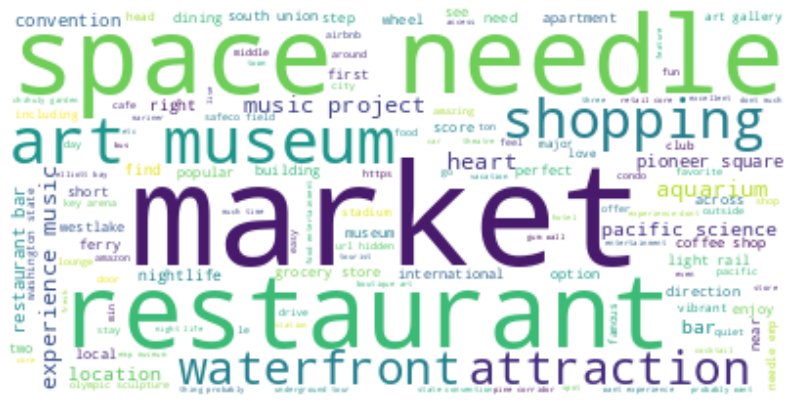

In [21]:
# downtown
utils.create_wordcloud(downtown, 'neighborhood_overview_cleaned')

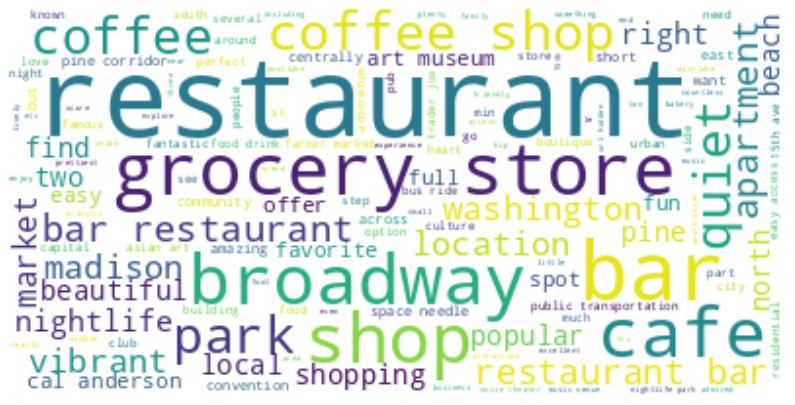

In [22]:
# capitol hill
utils.create_wordcloud(capitolHill, 'neighborhood_overview_cleaned')

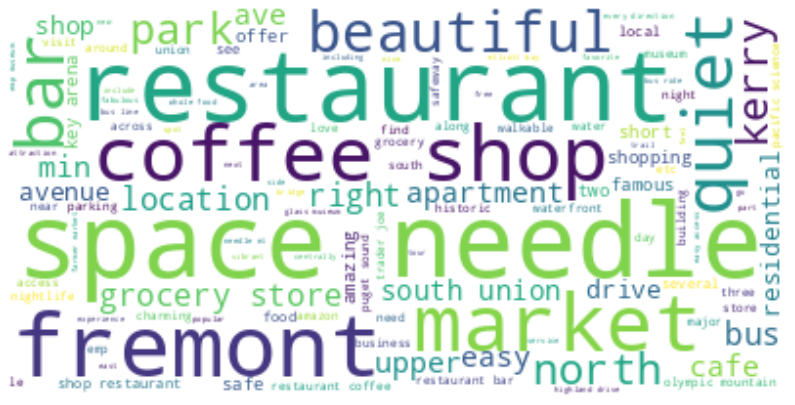

In [23]:
# queen anne
utils.create_wordcloud(queenAnne, 'neighborhood_overview_cleaned')

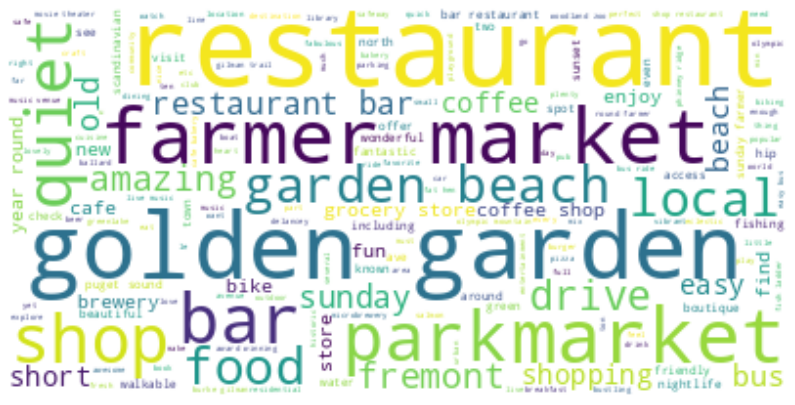

In [24]:
# ballard
utils.create_wordcloud(ballard, 'neighborhood_overview_cleaned')

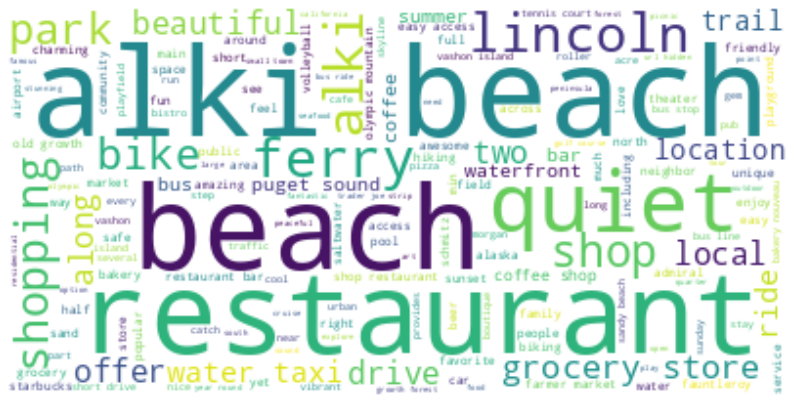

In [25]:
# west seattle
utils.create_wordcloud(weatSeattle, 'neighborhood_overview_cleaned')

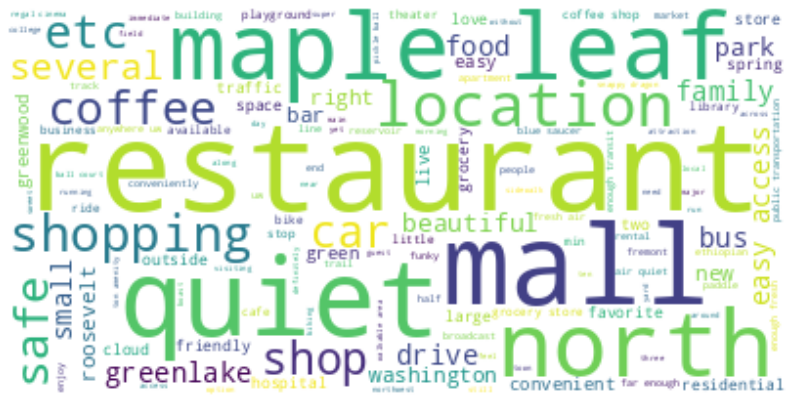

In [26]:
# north gate
utils.create_wordcloud(northgate, 'neighborhood_overview_cleaned')

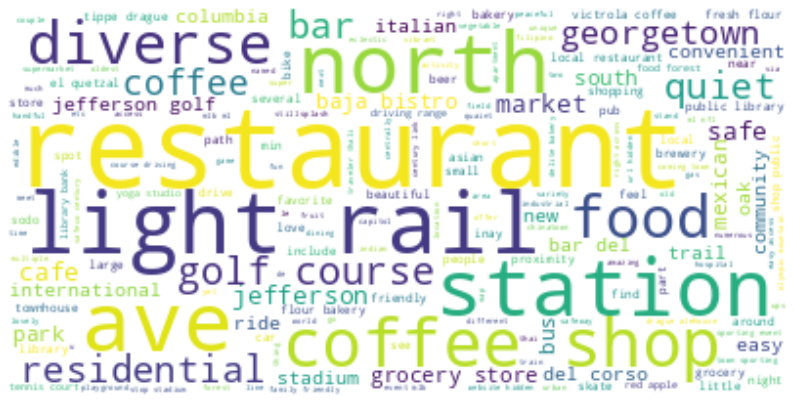

In [27]:
# beacon hill
utils.create_wordcloud(beaconHill, 'neighborhood_overview_cleaned')